In [14]:
# Import required libraries
import os
import pickle
import json
import numpy as np
from itertools import product
from sklearn.metrics import precision_recall_curve, auc
from run import symbol_detection_pipeline


In [15]:
# Load templates and reference colors
pickle_path = "data/templates.pkl"

with open(pickle_path, "rb") as f:
    reference_colors, all_templates = pickle.load(f)

print(f"Loaded {len(all_templates)} templates")
print(f"Reference colors shape: {np.array(reference_colors).shape}")


Loaded 24 templates
Reference colors shape: (4, 3)


In [16]:
# Load ground truth
with open("data/groundtruth.json", "r") as f:
    ground_truth = json.load(f)

print(f"Ground truth loaded for {len(ground_truth)} images")
print("Sample ground truth:", dict(list(ground_truth.items())[:3]))


Ground truth loaded for 33 images
Sample ground truth: {'positive_00000.jpeg': ['GHS_00012', 'GHS_00017'], 'positive_00001.jpeg': ['GHS_00016'], 'positive_00002.jpeg': ['GHS_00012']}


In [17]:
# Get list of test images
image_dir = "data/images/"
test_images = [f for f in os.listdir(image_dir) if f.endswith(('.jpeg', '.jpg', '.png'))]
test_images.sort()

print(f"Found {len(test_images)} test images")
print("Test images:", test_images[:5], "...")


Found 33 test images
Test images: ['positive_00000.jpeg', 'positive_00001.jpeg', 'positive_00002.jpeg', 'positive_00003.jpeg', 'positive_00004.jpeg'] ...


In [18]:
# Define parameter grids (all except ncc_threshold)
param_grid = {
    'rgb_threshold': [0.3], 
    'black_val_threshold': [50], 
    'white_sat_threshold': [0.1], 
    'white_val_threshold': [100], 
    'min_line_length_percent': [0.03], 
    'adjacency_radius': [6], 
    'dedup_thresh': [100], 
    'scale': [2],
    'num_octaves': [4], 
    'angle_tolerance': [5], 
    'distance_tolerance': [2] 
}

# NCC threshold range 
ncc_thresholds = np.arange(0, 1, 0.05) 

print("Parameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
print(f"\nNCC thresholds: {ncc_thresholds}")

# Calculate total number of experiments
total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)
print(f"\nTotal parameter combinations: {total_combinations}")
print(f"Total experiments (with NCC variations): {total_combinations * len(ncc_thresholds)}")


Parameter grid:
  rgb_threshold: [0.3]
  black_val_threshold: [50]
  white_sat_threshold: [0.1]
  white_val_threshold: [100]
  min_line_length_percent: [0.03]
  adjacency_radius: [6]
  dedup_thresh: [100]
  scale: [2]
  num_octaves: [4]
  angle_tolerance: [5]
  distance_tolerance: [2]

NCC thresholds: [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95]

Total parameter combinations: 1
Total experiments (with NCC variations): 20


In [19]:
# Helper function to extract template names from results
def extract_template_names(results):
    """Extract template names from pipeline results"""
    if 'matches' not in results:
        return []
    return [match['template_name'] for match in results['matches']]


In [20]:
# Helper function to compute precision and recall for a single image
def compute_precision_recall(predicted_templates, ground_truth_templates):
    """Compute precision and recall for a single image"""
    if not predicted_templates and not ground_truth_templates:
        return 1.0, 1.0 
    if not predicted_templates:
        return 1.0, 0.0 
    if not ground_truth_templates:
        return 0.0, 1.0 
    
    predicted_set = set(predicted_templates)
    ground_truth_set = set(ground_truth_templates)
    
    true_positives = len(predicted_set.intersection(ground_truth_set))
    
    precision = true_positives / len(predicted_set) if predicted_set else 0.0
    recall = true_positives / len(ground_truth_set) if ground_truth_set else 0.0
    
    return precision, recall

# Helper function to compute F1 score
def compute_f1_score(precision, recall):
    """Compute F1 score from precision and recall"""
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)


In [21]:
# Helper function to evaluate a single experiment across all NCC thresholds
def evaluate_experiment(params, experiment_id):
    """Evaluate a single parameter combination across all NCC thresholds"""
    print(f"\n=== Experiment {experiment_id} ===")
    print(f"Parameters: {params}")
    
    precision_scores = []
    recall_scores = []
    
    # Track per-image performance across all NCC thresholds
    per_image_f1_scores = {image_name: [] for image_name in test_images}
    per_image_precision_scores = {image_name: [] for image_name in test_images}
    per_image_recall_scores = {image_name: [] for image_name in test_images}
    
    for ncc_idx, ncc_threshold in enumerate(ncc_thresholds):
        print(f"  NCC threshold {ncc_idx+1}/{len(ncc_thresholds)}: {ncc_threshold:.2f}")
        
        image_precisions = []
        image_recalls = []
        
        for img_idx, image_name in enumerate(test_images):
            if img_idx % 5 == 0: 
                print(f"    Processing image {img_idx+1}/{len(test_images)}: {image_name}")
            
            image_path = os.path.join(image_dir, image_name)
            ground_truth_templates = ground_truth.get(image_name, [])
            
            try:
                results = symbol_detection_pipeline(
                    image_path=image_path,
                    templates=all_templates,
                    reference_colors=reference_colors,
                    ncc_threshold=ncc_threshold,
                    **params
                )
                
                predicted_templates = extract_template_names(results)
                precision, recall = compute_precision_recall(predicted_templates, ground_truth_templates)
                f1 = compute_f1_score(precision, recall)
                
                image_precisions.append(precision)
                image_recalls.append(recall)
                
                # Track per-image scores
                per_image_precision_scores[image_name].append(precision)
                per_image_recall_scores[image_name].append(recall)
                per_image_f1_scores[image_name].append(f1)
                
            except Exception as e:
                print(f"    Error processing {image_name}: {e}")
                
                image_precisions.append(0.0)
                image_recalls.append(0.0)
                
                # Track failed cases
                per_image_precision_scores[image_name].append(0.0)
                per_image_recall_scores[image_name].append(0.0)
                per_image_f1_scores[image_name].append(0.0)
        
        avg_precision = np.mean(image_precisions)
        avg_recall = np.mean(image_recalls)
        
        precision_scores.append(avg_precision)
        recall_scores.append(avg_recall)
        
        print(f"    Avg Precision: {avg_precision:.3f}, Avg Recall: {avg_recall:.3f}")
    
    # Compute average F1 score per image across all NCC thresholds
    avg_f1_per_image = {
        image_name: np.mean(f1_scores) 
        for image_name, f1_scores in per_image_f1_scores.items()
    }
    
    # Sort images by performance
    sorted_images_by_f1 = sorted(avg_f1_per_image.items(), key=lambda x: x[1], reverse=True)
    
    # Print per-image performance
    print(f"  Per-image F1 performance (averaged across all NCC thresholds):")
    print(f"  Best performing images:")
    for i, (image_name, avg_f1) in enumerate(sorted_images_by_f1[:3]):
        print(f"    {i+1}. {image_name}: F1 = {avg_f1:.3f}")
    
    print(f"  Worst performing images:")
    for i, (image_name, avg_f1) in enumerate(sorted_images_by_f1[-3:]):
        print(f"    {len(sorted_images_by_f1)-2+i}. {image_name}: F1 = {avg_f1:.3f}")
    
    # Compute AUPRC (Area Under Precision-Recall Curve)
    sorted_indices = np.argsort(recall_scores)
    sorted_recalls = np.array(recall_scores)[sorted_indices]
    sorted_precisions = np.array(precision_scores)[sorted_indices]
    
    auprc = auc(sorted_recalls, sorted_precisions)
    
    print(f"  AUPRC: {auprc:.4f}")
    
    return {
        'experiment_id': experiment_id,
        'parameters': params,
        'ncc_thresholds': ncc_thresholds.tolist(),
        'precision_scores': precision_scores,
        'recall_scores': recall_scores,
        'auprc': auprc,
        'per_image_f1_scores': per_image_f1_scores,
        'per_image_precision_scores': per_image_precision_scores,
        'per_image_recall_scores': per_image_recall_scores,
        'avg_f1_per_image': avg_f1_per_image
    }


In [22]:
# Main grid search execution
print("Starting grid search...")
print(f"Total combinations to evaluate: {total_combinations}")

results_list = []
experiment_id = 0

# Generate all parameter combinations
param_names = list(param_grid.keys())
param_values = list(param_grid.values())

from tqdm import tqdm

for combination in tqdm(list(product(*param_values)), total=total_combinations, desc="Grid Search Experiments"):
    experiment_id += 1

    params = dict(zip(param_names, combination))

    experiment_result = evaluate_experiment(params, experiment_id)
    results_list.append(experiment_result)

print(f"\nGrid search completed! Evaluated {len(results_list)} experiments.")


Starting grid search...
Total combinations to evaluate: 1


Grid Search Experiments:   0%|          | 0/1 [00:00<?, ?it/s]


=== Experiment 1 ===
Parameters: {'rgb_threshold': 0.3, 'black_val_threshold': 50, 'white_sat_threshold': 0.1, 'white_val_threshold': 100, 'min_line_length_percent': 0.03, 'adjacency_radius': 6, 'dedup_thresh': 100, 'scale': 2, 'num_octaves': 4, 'angle_tolerance': 5, 'distance_tolerance': 2}
  NCC threshold 1/20: 0.00
    Processing image 1/33: positive_00000.jpeg
Time taken to load image: 0.01826310157775879 seconds
Time taken to get 6 color masks: 0.3907136917114258 seconds
Found 2718 segments over all masks
Post-processing mask 0
Found 104 segments after merging
Found 40 loops
Found 4 quads
Post-processing mask 1
Found 59 segments after merging
Found 1 loops
Found 0 quads
Post-processing mask 2
Found 23 segments after merging
Found 0 loops
Found 0 quads
Post-processing mask 3
Found 798 segments after merging
Found 58 loops
Found 0 quads
Post-processing mask 4
Found 377 segments after merging
Found 33 loops
Found 0 quads
Post-processing mask 5
Found 724 segments after merging
Found 

/Users/frbuccoliero/Desktop/Thesis/Tests/final_pipeline/run.py:141: RuntimeWarning: overflow encountered in scalar multiply
  return ab[0]*bc[1] - ab[1]*bc[0]


Time taken to get 6 color masks: 0.11768794059753418 seconds
Found 462 segments over all masks
Post-processing mask 0
Found 99 segments after merging
Found 24 loops
Found 3 quads
Post-processing mask 1
Found 0 segments after merging
Found 0 loops
Found 0 quads
Post-processing mask 2
Found 0 segments after merging
Found 0 loops
Found 0 quads
Post-processing mask 3
Found 121 segments after merging
Found 29 loops
Found 0 quads
Post-processing mask 4
Found 10 segments after merging
Found 0 loops
Found 0 quads
Post-processing mask 5
Found 122 segments after merging
Found 12 loops
Found 2 quads
Found 5 quads over all masks before deduplication
Found 2 quads over all masks after deduplication
Time taken to get 2 quads: 0.47324109077453613 seconds
Checking candidate 0
** Found GHS_00000 with NCC score 0.5930764675140381 **
** Found GHS_00009 with NCC score 0.6033005118370056 **
** Found GHS_00012 with NCC score 0.6750051379203796 **
** Found GHS_00013 with NCC score 0.705111026763916 **
** Fou

Grid Search Experiments: 100%|██████████| 1/1 [06:51<00:00, 411.74s/it]

NCC score 0.683594822883606 for GHS_00014 is below threshold 0.9500000000000001
NCC score 0.7248732447624207 for GHS_00015 is below threshold 0.9500000000000001
NCC score 0.7224464416503906 for GHS_00016 is below threshold 0.9500000000000001
NCC score 0.7000330090522766 for GHS_00017 is below threshold 0.9500000000000001
NCC score 0.6460102200508118 for GHS_00018 is below threshold 0.9500000000000001
NCC score 0.626841127872467 for GHS_00019 is below threshold 0.9500000000000001
NCC score 0.6925826072692871 for GHS_00020 is below threshold 0.9500000000000001
Checking candidate 1
NCC score 0.4827868938446045 for GHS_00006 is below threshold 0.9500000000000001
Checking candidate 2
Checking candidate 3
NCC score 0.1456553041934967 for GHS_00000 is below threshold 0.9500000000000001
NCC score 0.25598475337028503 for GHS_00001 is below threshold 0.9500000000000001
NCC score 0.2509886622428894 for GHS_00002 is below threshold 0.9500000000000001
NCC score 0.2734293043613434 for GHS_00003 is b

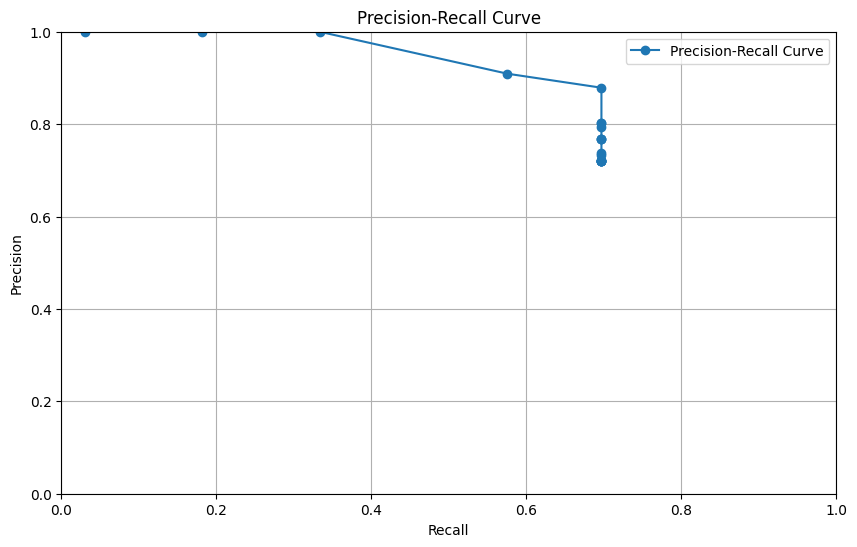

In [23]:
# plot the auprc for the last result

precisions = results_list[-1]['precision_scores']
recalls = results_list[-1]['recall_scores']

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, marker='o', label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.show()

In [24]:
# Analyze results
print("\n=== RESULTS SUMMARY ===")

# Sort results by AUPRC
sorted_results = sorted(results_list, key=lambda x: x['auprc'], reverse=True)

print(f"\nTop 5 experiments by AUPRC:")
for i, result in enumerate(sorted_results[:5]):
    print(f"{i+1}. Experiment {result['experiment_id']}: AUPRC = {result['auprc']:.4f}")
    print(f"   Parameters: {result['parameters']}")

print(f"\nWorst 5 experiments by AUPRC:")
for i, result in enumerate(sorted_results[-5:]):
    print(f"{len(sorted_results)-4+i}. Experiment {result['experiment_id']}: AUPRC = {result['auprc']:.4f}")
    print(f"   Parameters: {result['parameters']}")

# Statistics
auprc_scores = [r['auprc'] for r in results_list]
print(f"\nAUPRC Statistics:")
print(f"  Mean: {np.mean(auprc_scores):.4f}")
print(f"  Std:  {np.std(auprc_scores):.4f}")
print(f"  Min:  {np.min(auprc_scores):.4f}")
print(f"  Max:  {np.max(auprc_scores):.4f}")

# Per-image analysis across all experiments
print(f"\n=== PER-IMAGE PERFORMANCE ANALYSIS ===")

# Collect F1 scores for each image across all experiments
image_f1_across_experiments = {image_name: [] for image_name in test_images}

for result in results_list:
    for image_name, avg_f1 in result['avg_f1_per_image'].items():
        image_f1_across_experiments[image_name].append(avg_f1)

# Compute statistics for each image
image_f1_stats = {}
for image_name, f1_scores in image_f1_across_experiments.items():
    image_f1_stats[image_name] = {
        'mean': np.mean(f1_scores),
        'std': np.std(f1_scores),
        'min': np.min(f1_scores),
        'max': np.max(f1_scores)
    }

# Sort images by average performance across all experiments
sorted_images_overall = sorted(image_f1_stats.items(), key=lambda x: x[1]['mean'], reverse=True)

print(f"\nOverall best performing images (across all experiments):")
for i, (image_name, stats) in enumerate(sorted_images_overall[:10]):
    print(f"{i+1}. {image_name}: Mean F1 = {stats['mean']:.3f} ± {stats['std']:.3f} (range: {stats['min']:.3f}-{stats['max']:.3f})")

print(f"\nOverall worst performing images (across all experiments):")
for i, (image_name, stats) in enumerate(sorted_images_overall[-10:]):
    rank = len(sorted_images_overall) - 4 + i
    print(f"{rank}. {image_name}: Mean F1 = {stats['mean']:.3f} ± {stats['std']:.3f} (range: {stats['min']:.3f}-{stats['max']:.3f})")

# Find most consistent and most variable images
sorted_by_std = sorted(image_f1_stats.items(), key=lambda x: x[1]['std'])
print(f"\nMost consistent images (lowest F1 standard deviation):")
for i, (image_name, stats) in enumerate(sorted_by_std[:3]):
    print(f"{i+1}. {image_name}: Mean F1 = {stats['mean']:.3f} ± {stats['std']:.3f}")

print(f"\nMost variable images (highest F1 standard deviation):")
for i, (image_name, stats) in enumerate(sorted_by_std[-3:]):
    rank = len(sorted_by_std) - 2 + i
    print(f"{rank}. {image_name}: Mean F1 = {stats['mean']:.3f} ± {stats['std']:.3f}")



=== RESULTS SUMMARY ===

Top 5 experiments by AUPRC:
1. Experiment 1: AUPRC = 0.6428
   Parameters: {'rgb_threshold': 0.3, 'black_val_threshold': 50, 'white_sat_threshold': 0.1, 'white_val_threshold': 100, 'min_line_length_percent': 0.03, 'adjacency_radius': 6, 'dedup_thresh': 100, 'scale': 2, 'num_octaves': 4, 'angle_tolerance': 5, 'distance_tolerance': 2}

Worst 5 experiments by AUPRC:
-3. Experiment 1: AUPRC = 0.6428
   Parameters: {'rgb_threshold': 0.3, 'black_val_threshold': 50, 'white_sat_threshold': 0.1, 'white_val_threshold': 100, 'min_line_length_percent': 0.03, 'adjacency_radius': 6, 'dedup_thresh': 100, 'scale': 2, 'num_octaves': 4, 'angle_tolerance': 5, 'distance_tolerance': 2}

AUPRC Statistics:
  Mean: 0.6428
  Std:  0.0000
  Min:  0.6428
  Max:  0.6428

=== PER-IMAGE PERFORMANCE ANALYSIS ===

Overall best performing images (across all experiments):
1. positive_00024.jpeg: Mean F1 = 1.000 ± 0.000 (range: 1.000-1.000)
2. positive_00002.jpeg: Mean F1 = 0.950 ± 0.000 (range

In [25]:
# Detailed analysis of best experiment
if results_list:
    print("\n=== DETAILED ANALYSIS OF BEST EXPERIMENT ===")
    
    best_experiment = sorted_results[0]
    print(f"Best Experiment #{best_experiment['experiment_id']} (AUPRC: {best_experiment['auprc']:.4f})")
    print(f"Parameters: {best_experiment['parameters']}")
    
    # Show F1 scores for each image in the best experiment
    best_exp_image_f1 = best_experiment['avg_f1_per_image']
    sorted_best_exp_images = sorted(best_exp_image_f1.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\nPer-image F1 scores in best experiment:")
    for i, (image_name, f1_score) in enumerate(sorted_best_exp_images):
        gt_templates = ground_truth.get(image_name, [])
        print(f"  {i+1:2d}. {image_name}: F1 = {f1_score:.3f} (Ground truth: {gt_templates})")
    
    # Show performance across NCC thresholds for the best and worst image
    if sorted_best_exp_images:
        best_image = sorted_best_exp_images[0][0]
        worst_image = sorted_best_exp_images[-1][0]
        
        print(f"\nF1 scores across NCC thresholds for best image ({best_image}):")
        best_image_f1_scores = best_experiment['per_image_f1_scores'][best_image]
        for i, (ncc_thresh, f1) in enumerate(zip(ncc_thresholds, best_image_f1_scores)):
            print(f"  NCC {ncc_thresh:.2f}: F1 = {f1:.3f}")
        
        print(f"\nF1 scores across NCC thresholds for worst image ({worst_image}):")
        worst_image_f1_scores = best_experiment['per_image_f1_scores'][worst_image]
        for i, (ncc_thresh, f1) in enumerate(zip(ncc_thresholds, worst_image_f1_scores)):
            print(f"  NCC {ncc_thresh:.2f}: F1 = {f1:.3f}")
else:
    print("No results to analyze.")



=== DETAILED ANALYSIS OF BEST EXPERIMENT ===
Best Experiment #1 (AUPRC: 0.6428)
Parameters: {'rgb_threshold': 0.3, 'black_val_threshold': 50, 'white_sat_threshold': 0.1, 'white_val_threshold': 100, 'min_line_length_percent': 0.03, 'adjacency_radius': 6, 'dedup_thresh': 100, 'scale': 2, 'num_octaves': 4, 'angle_tolerance': 5, 'distance_tolerance': 2}

Per-image F1 scores in best experiment:
   1. positive_00024.jpeg: F1 = 1.000 (Ground truth: [])
   2. positive_00002.jpeg: F1 = 0.950 (Ground truth: ['GHS_00012'])
   3. positive_00027.jpeg: F1 = 0.950 (Ground truth: ['GHS_00014'])
   4. positive_00029.jpeg: F1 = 0.950 (Ground truth: ['GHS_00014'])
   5. positive_00000.jpeg: F1 = 0.917 (Ground truth: ['GHS_00012', 'GHS_00017'])
   6. positive_00006.jpeg: F1 = 0.900 (Ground truth: ['GHS_00012'])
   7. positive_00010.jpeg: F1 = 0.900 (Ground truth: ['GHS_00014'])
   8. positive_00023.jpeg: F1 = 0.900 (Ground truth: ['GHS_00012'])
   9. positive_00019.jpeg: F1 = 0.883 (Ground truth: ['GHS_0

In [26]:
# Save results to file
output_file = "grid_search_results.json"

with open(output_file, 'w') as f:
    json.dump(results_list, f, indent=2)

print(f"\nResults saved to {output_file}")
print(f"Total experiments saved: {len(results_list)}")



Results saved to grid_search_results.json
Total experiments saved: 1
